Final notebooks to include every graph/table

## Data

[Download](https://x.com/i/communitynotes/download-data) the data from x.com. The description of each dataset is [here](https://communitynotes.x.com/guide/en/under-the-hood/download-data).
For accessing the scores, the [note scoring algorithm](https://github.com/twitter/communitynotes) needs to applied on the provided datasets. 

In this notebook we applied scoring algorithm to the data before Feb 2025 and used it for Regression Discontinuty Desgin analysis (applied on 2024 data only). Otherwise, we used most recent note and note_history notebook containing data to end of June 2025.

[bring merge scripts and updaing dates here.]

# Environment

see requirements.txt or communitynotes2025-05-09.yml

# Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
from sklearn import linear_model
import statsmodels.formula.api as smf
import os
import itertools
from matplotlib.ticker import ScalarFormatter

In [6]:
# Files and locations
userloc = os.getcwd()
userloc = '/home/tom/Desktop/communitynotes'
data_raw = userloc+'/data/' # download from x.com
data_proc = userloc+'/data2025proc/' # generating by CN code, run on HPC
data_post = userloc+'/data2025post/' # post-processing, generated by our scripts

## Preprocessing
Our scripts

In [7]:
# preprocess dates
with open(data_raw+'notes-00000.tsv', 'r') as n:
    notes = pd.read_csv(n, sep='\t')


# create a column with datetime format
notes['createdAt'] = pd.to_datetime(notes['createdAtMillis'], unit='ms')
# add a columns for month and year
# notes[]
notes['createdAtYear'] = notes['createdAt'].dt.year
notes['createdAtMonth'] = notes['createdAt'].dt.month

# save in parquet format
notes.to_parquet(data_post + 'notes.parquet')

/tmp/ipykernel_102924/3259408385.py:3: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv(n, sep='\t')


In [8]:
# merge ratings, history and notes
# it assumes you already have run CN algorithm and have the output scored_notes.parquet

# use parquet format for faster loading
scored_notes = pd.read_parquet(data_proc + 'scored_notes.parquet', engine='auto')

notes = pd.read_parquet(data_post + 'notes.parquet', engine='auto')

with open(data_raw + 'noteStatusHistory-00000.tsv', 'r') as n:
    note_history = pd.read_csv(n, sep='\t')

#  merge scored notes and notes dataframes
df = pd.merge(scored_notes, notes, how='left', on='noteId')

# now merge with the note history data
df = pd.merge(df, note_history, how='left', on='noteId')

# rename duplicate columns
df.rename(columns={'noteAuthorParticipantId_x': 'noteAuthorParticipantId',
                   'classification_x': 'classification'}, inplace=True)

# only keep useful columns
df_short = df[
    ['noteId',
    'finalRatingStatus',
    'classification', # what the writer thinks about the original tweet
    'createdAtMillis',
    'createdAt',
    'createdAtYear',
    'createdAtMonth',
    'numRatings',
    'noteAuthorParticipantId',
    'tweetId',
    'firstNonNMRStatus',
    'currentStatus',
    'mostRecentNonNMRStatus',
    'lockedStatus',
    'coreNoteIntercept', 'coreNoteFactor1', 'coreRatingStatus',
    'decidedBy', 
    'expansionNoteIntercept', 'expansionNoteFactor1', 'expansionRatingStatus',
    'coverageNoteIntercept', 'coverageNoteFactor1', 'coverageRatingStatus',
    'coreNoteInterceptMin', 'coreNoteInterceptMax',
    'expansionNoteInterceptMin', 'expansionNoteInterceptMax',
    'coverageNoteInterceptMin', 'coverageNoteInterceptMax',
    'groupNoteIntercept', 'groupNoteFactor1', 'groupRatingStatus',
    'groupNoteInterceptMax', 'groupNoteInterceptMin', 
    'modelingGroup',
    'summary',
    'isMediaNote',]
]


df_short.to_parquet(data_post + 'rated_notes_compact.parquet')


/tmp/ipykernel_102924/2607659088.py:10: DtypeWarning: Columns (10,19) have mixed types. Specify dtype option on import or set low_memory=False.
  note_history = pd.read_csv(n, sep='\t')


In [9]:
# merge history with notes 
# since our scored_notes file was not updated for 2025 data, we used the ratingStatus from new version of 
# note history instead. The scored_note dataset has the scores, but the history dataset only has the
# helpfulness labels

with open(data_raw + 'noteStatusHistory-00000.tsv', 'r') as n:
    note_history = pd.read_csv(n, sep='\t')

notes = pd.read_parquet(data_post + 'notes.parquet', engine='auto')

#  merge the two dataframes
df = pd.merge(notes, note_history, how='left', on='noteId')

# rename duplicate columns
df.rename(columns={'noteAuthorParticipantId_x': 'noteAuthorParticipantId',
                   }, inplace=True)

# keep useful columns
df_short = df[
    ['noteId',
    'classification', # what the writer thinks about the original tweet
    'createdAt',
    'createdAtYear',
    'createdAtMonth',
    'noteAuthorParticipantId',
    'tweetId',
    'currentStatus',
    'summary',
    ]
]

df_short.to_parquet(data_post + 'notes_current_stat.parquet')


/tmp/ipykernel_102924/3932252996.py:7: DtypeWarning: Columns (10,19) have mixed types. Specify dtype option on import or set low_memory=False.
  note_history = pd.read_csv(n, sep='\t')


## Load data

In [10]:
# import notes
notes = pd.read_parquet(data_post + 'notes.parquet', engine='auto')
# limit it to the last day of June 2025
notes = notes[notes.createdAt < pd.Timestamp(2025, 7, 1)]

In [11]:
# note history with current status of helpfulness labels
notes_and_status = pd.read_parquet(data_post + 'notes_current_stat.parquet',\
                                    engine='auto')

# note that the labels agree with finalRatingStatus in more than 95% of the times 

In [12]:
rated = pd.read_parquet(data_post + 'rated_notes_compact.parquet', engine='auto')

### Active authors per month
written at least one note in the reference month

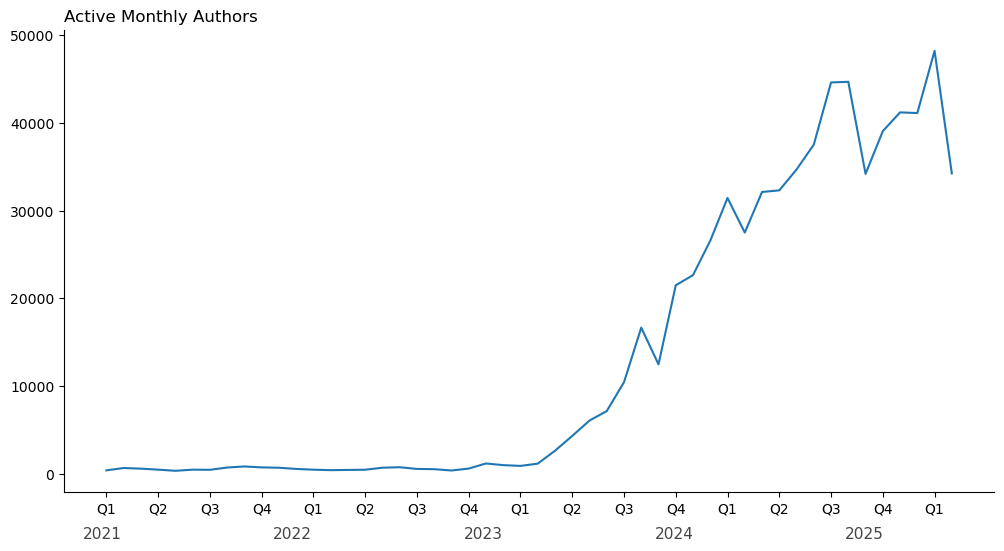

In [13]:
# active users per month
active_authors_monthly = notes.groupby(['createdAtYear', 'createdAtMonth'])\
    .agg({'noteAuthorParticipantId': 'nunique'}).reset_index()
active_authors_monthly.rename(columns={'noteAuthorParticipantId': 'count'}, inplace=True)
# plot active authors monthly
fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(active_authors_monthly.index,active_authors_monthly['count'])
ax.plot(active_authors_monthly['count'])

ax.set_xticks(np.arange(0,len(active_authors_monthly), step=3))
# set quartely labels
labels = [''] * len(ax.get_xticks())
for idx, element in enumerate(labels):
    labels[idx] = 'Q' + str(idx%4 + 1)

ax.set_xticklabels(labels)
# add years
for idx, year in enumerate(range(2021,2026)):
    ax.text(idx*.205 + .02 , -.1, str(year), size=11, color='#444', transform=ax.transAxes)
ax.set_title('Active Monthly Authors', loc='left')
ax.spines[['right', 'top']].set_visible(False)

### Natality to Mortality ratio

New calculations for the number of people moving into and out of the system

In [14]:
# First, we can simplify the df - all that matters are timestamsp of when notes authored, and who authored them

smol = ['createdAt','noteAuthorParticipantId']

#collect all createdAt dates in a list, with rows for each author
createdAt_dates = notes[smol].groupby('noteAuthorParticipantId').agg(list).reset_index()



In [15]:
def countdeaths(row,year,month):
    '''function for calculating deaths per month, using a limited window for looking ahead'''
    # LOGIC PER ROW
    #if author is alive this month
    #    does author post in the next W months?
    #        if no, deaths+=1 for this month
    #else
    #    author is not born yet: no action
    #OR
    #    author was alive in a previous month, so
    #    author didn't post this month, but will in next months, continuing their life
    #    author didn't post this month, and won't in the next months, meaning their death is registered for a previous month
    

    tstamps  = pd.Series(row['createdAt'])

    w = 4 #window for looking forward, in months

    found = True 

    # post in key month
    if any ((tstamps.dt.year == year) & (tstamps.dt.month == month)):
        #print('yes 0')
        found = False
        for i in range(0,w):
            month = month + 1
            if month > 12:
                month = month - 12
                year = year + 1

            if any ((tstamps.dt.year == year) & (tstamps.dt.month == month)):
                #print('yes'+str(i+1))
                found = True
                break
            else:
                pass

    

    if found:
        return 0 # either didn't post (original state) or did post but then posted in next w months = no death
    else:
        return 1 # only if posted in key month and then not found subsequently = death


In [16]:
# Apply the 'look ahead' method to calculate deaths per month, for each month in 2024

#takes 20m45s
for year in range(2024,2025):
    for month in range(1,13):
        colname = 'Deaths_'+str(year)+'-'+str(month).zfill(2)
        print(colname)
        createdAt_dates[colname]=createdAt_dates.apply(countdeaths, axis=1, args=(year, month))

# Generate a list of the column names from '2024-01' to '2024-12'
month_columns = [f'Deaths_2024-{str(i).zfill(2)}' for i in range(1, 13)]

# Select and sum the columns vertically
deaths = createdAt_dates[month_columns].sum(axis=0)

#createdAt_dates.head().to_csv('temp.csv')

Deaths_2024-01
Deaths_2024-02
Deaths_2024-03
Deaths_2024-04
Deaths_2024-05
Deaths_2024-06
Deaths_2024-07
Deaths_2024-08
Deaths_2024-09
Deaths_2024-10
Deaths_2024-11
Deaths_2024-12


In [17]:
# Calculate births and deaths, using the 'absolute' method
# births = someone posts their first note
# deaths = someone posts their last note (in the data we have). 
# This will systyematically overestimate deaths towards the end of the data series
# e.g. people who authors every other months will look like they "die" in the penultimnate monthy of the series

# every note author has a month indicating the date of their first note. This is when they are 'born
# Find the first note date for each author
first_note = notes.groupby('noteAuthorParticipantId')['createdAt'].min().reset_index()
first_note.rename(columns={'createdAt': 'first_note_date'}, inplace=True)

#sanity check - we are including the full data
first_note['first_note_date'].min() #Timestamp('2021-01-28 00:27:47.892000')

# every note author has a month indicating the data of their last note. 
# nb this only indicated mortality if there is some distance between the last note data and the end of the data
last_note = notes.groupby('noteAuthorParticipantId')['createdAt'].max().reset_index()
last_note.rename(columns={'createdAt': 'last_note_date'}, inplace=True)

# collect first and last note date for each author
ppts = pd.merge(first_note,last_note,on='noteAuthorParticipantId')

# convert dates to a common, componsit format: yyyymm
ppts['first_yearmonth']= pd.to_datetime(ppts['first_note_date']).dt.year*100 + pd.to_datetime(ppts['first_note_date']).dt.month
ppts['last_yearmonth']= pd.to_datetime(ppts['last_note_date']).dt.year*100 + pd.to_datetime(ppts['last_note_date']).dt.month



# count births in each month
born = ppts.groupby('first_yearmonth')['noteAuthorParticipantId'].count()
#remove count for early than 2024  yearmonths < 202401
born = born[born.index >= 202401]
born = born.reset_index()
#rename columns
born.rename(columns={'first_yearmonth':'month','noteAuthorParticipantId': 'born'}, inplace=True)

# count deaths in each month (but recall provisio about end of data)
died = ppts.groupby('last_yearmonth')['noteAuthorParticipantId'].count()
#remove count for early than 2024
died = died[died.index >= 202401]
died = died.reset_index()
died.rename(columns={'last_yearmonth':'month','noteAuthorParticipantId': 'died'}, inplace=True)

#merge
natality = pd.merge(born, died, how='left', on='month')
# calculate net births - deaths
natality['net'] = natality['born'] - natality['died']    

# reconstruct date from composit in YYYY-MM format
natality['year'] = natality['month'].astype(str).str[:4]
natality['month'] = natality['month'].astype(str).str[-2:]
natality['date'] = natality['year'] + '-' + natality['month']

#only 2024 data, since last note date only indicated dormancy for up to 4 months before data ends
natality = natality[natality['year'] == '2024']


## Absolute method: net births - deaths

<Figure size 640x480 with 0 Axes>

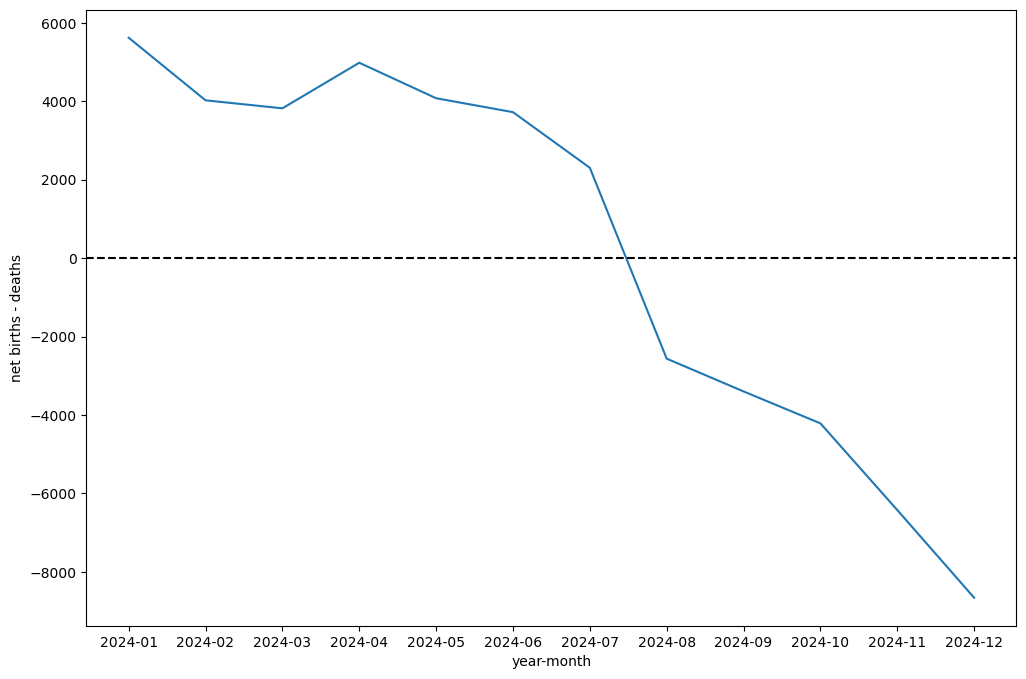

In [18]:


plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(natality['date'], natality['net'])
#add horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')
# add label for horizon line
plt.text(x=0.5, y=0, s=None,ha='center', va='center', color='black')
plt.xlabel('year-month')
plt.ylabel('net births - deaths')
plt.savefig('plots/natality.png',bbox_inches='tight',dpi=120)

#fundamentally this in 'unfair' because months earlier in the series have longer for authors to 'revive'
# calculate using "look ahead" method


## Recalculate net births and using the window method


<Figure size 640x480 with 0 Axes>

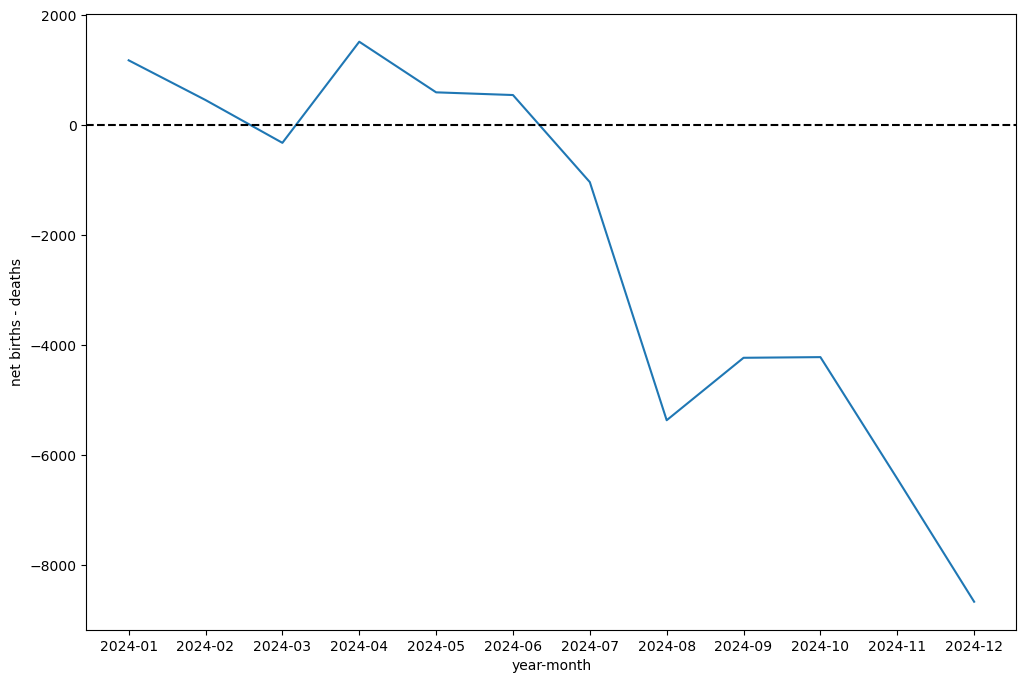

In [19]:

net= natality['born'].values - deaths.values

plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(natality['date'], net)
#add horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')
# add label for horizon line
plt.text(x=0.5, y=0, s=None,ha='center', va='center', color='black')
plt.xlabel('year-month')
plt.ylabel('net births - deaths')
plt.savefig('plots/natality_recalc.png',bbox_inches='tight',dpi=120)





## Raw figures

<Figure size 640x480 with 0 Axes>

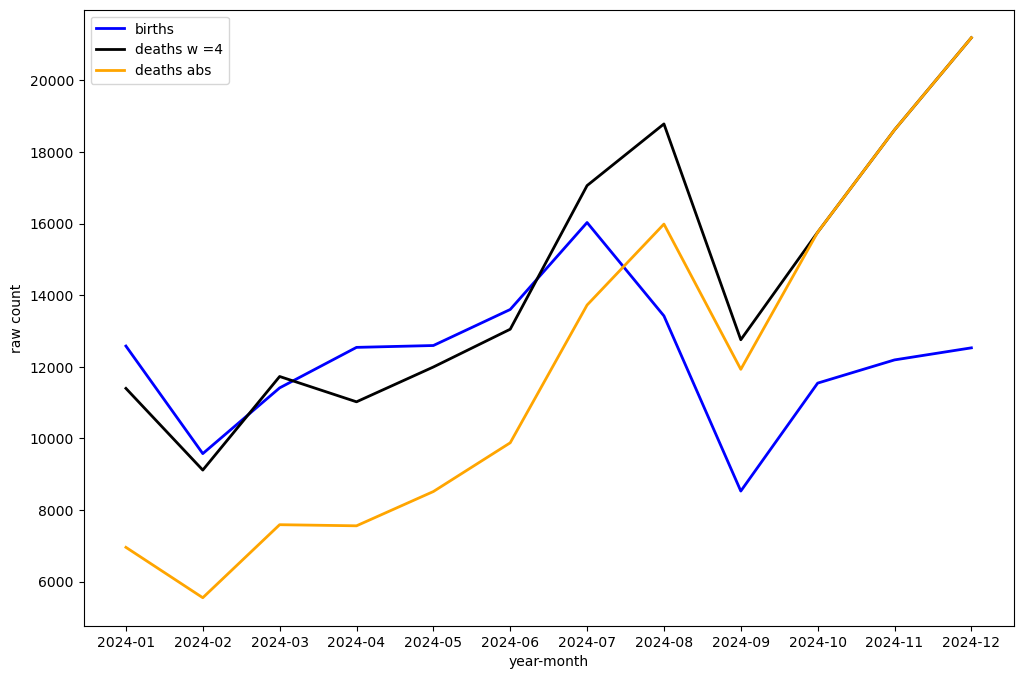

In [20]:
plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(natality['date'], natality['born'], color='blue', linewidth=2,label='births')
plt.plot(natality['date'], deaths.values, color='black', linewidth=2,label='deaths w =4')
plt.plot(natality['date'], natality['died']  , color='orange', linewidth=2,label='deaths abs')
#add horizontal line at 0
#plt.axhline(y=0, color='black', linestyle='--')
# add label for horizon line
#plt.text(x=0.5, y=0, s=None,ha='center', va='center', color='black')
plt.xlabel('year-month')
plt.ylabel('raw count')
plt.legend(loc='upper left')
plt.savefig('plots/natality_raw.png',bbox_inches='tight',dpi=120)

In [21]:
## OLD METHOD - ratio

In [22]:

# Merge the first note dates back into the original DataFrame
df = pd.merge(notes, first_note, on='noteAuthorParticipantId')

# Calculate the date 4 months after the first note - this is NOT right, since 
df['four_months_after_first'] = df['first_note_date'] + pd.DateOffset(months=n)

# Filter for notes within 4 months
df['note_within_n_months'] = (df['createdAt'] > df['first_note_date']) & \
    (df['createdAt'] <= df['four_months_after_first'])

# Aggregate to determine if any note was made in the 4 months
df = df.groupby('noteAuthorParticipantId')['note_within_n_months'].any().reset_index()


# merge author list with first note df
first_note = pd.merge(first_note, df, on='noteAuthorParticipantId')
# remove authors who joined n months before the last date of the data or before jan 2024
first_note = first_note[
    (first_note['first_note_date'] < (notes['createdAt'].max() - pd.DateOffset(months=n))) &
    (first_note['first_note_date'] >= pd.Timestamp(2024, 1, 1))]
# now count monthly
df_monthly = first_note.set_index('first_note_date').resample('MS').count()
df_monthly['written_again'] = first_note.groupby(pd.Grouper(key='first_note_date', freq='MS'))\
    ['note_within_n_months'].sum()
df_monthly['not_written_again'] = df_monthly['note_within_n_months'] - df_monthly['written_again']
df_monthly.reset_index(inplace=True)
df_monthly.drop('noteAuthorParticipantId', axis=1, inplace=True)
df_monthly.rename(columns={'note_within_n_months': 'count_author'}, inplace=True)




TypeError: int() argument must be a string, a bytes-like object or a real number, not '_io.TextIOWrapper'

In [ ]:


# plot 
# Let's check born/dead ratio
# dead: someone who writes their last note (by checking activity in the next n months)
# born: for 1st time: write their 1st note
ax = plt.subplot()

sns.lineplot(x=df_monthly['first_note_date'], 
             y=df_monthly['count_author']/df_monthly['not_written_again'],
             ax=ax)
ax.set_title('Natality to Mortality among first-time authors',
             loc='left',
             x=0, y=1.05)
ax.set_ylabel('')
ax.set_xlabel('')


KeyError: 13

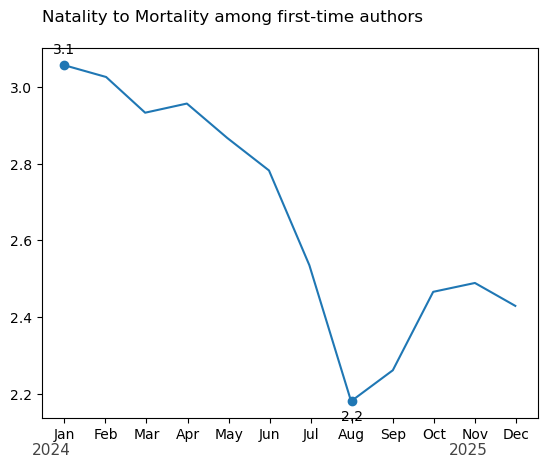

In [ ]:

x_labels = [calendar.month_abbr[month] for month in df_monthly.first_note_date.dt.month]

# default labels were every 2 months
x_loc_def = ax.get_xticks()
# calculate the distance between each consequetive month
dist = (x_loc_def[1] - x_loc_def[0]) / 2
# new locations for x ticks
x_locs = [x_loc_def[0] + i* (dist+.5) for i in range(len(x_labels))]

ax.set_xticks(x_locs)
ax.set_xticklabels(x_labels)

# add years
ax.text(-.02, -.1, 2024, size=11, color='#444', transform=ax.transAxes)
ax.text(.82, -.1, 2025, size=11, color='#444', transform=ax.transAxes)

# add text to max and two mins
for month in [1,8, 14]:
    x = month-1
    y = df_monthly.loc[x]['count_author']/df_monthly.loc[x]['not_written_again']
    ax.plot(x_locs[x],
            y,
            marker='o',
            color='tab:blue')
    if month == 1:
        ax.text(x_locs[x],
                y+.03,
                f"{y:.1f}",
                ha='center')
    else:
        ax.text(x_locs[x],
                y-.05,
                f"{y:.1f}",
                ha='center')

ax.set_ylim(2.1)
ax.tick_params(axis='both', colors="#444444", labelleft=False, left=False, bottom=False)
ax.spines[['bottom']].set_color("grey")
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#444444')
ax.tick_params(axis='both', colors='#444444')
plt.show()